In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime
from datetime import datetime
from scipy.stats import pearsonr
from sdv.tabular import GaussianCopula

In [48]:
# df_raw = pd.read_csv("dude.csv")
# df_raw.head(5)
# print('Num rows: %d' %len(df_raw))
loaded = GaussianCopula.load('synth_model.pkl')
df_clean = loaded.sample(1000)

In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1000 non-null   float64
 1   name                     1000 non-null   object 
 2   first                    1000 non-null   object 
 3   last                     1000 non-null   object 
 4   compas_screening_date    1000 non-null   object 
 5   sex                      856 non-null    object 
 6   dob                      1000 non-null   object 
 7   age                      1000 non-null   float64
 8   age_cat                  959 non-null    object 
 9   race                     990 non-null    object 
 10  juv_fel_count            1000 non-null   float64
 11  decile_score             1000 non-null   float64
 12  juv_misd_count           1000 non-null   float64
 13  juv_other_count          1000 non-null   float64
 14  priors_count             

Not all rows are necessary/beneficial for first round of analysis.
Some of the preliminary preprocessing has been borrowed from ProPublica's initial steps in order to keep my analysis consistent.

Some reasons for row removal:
- Missing data
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- Inserted the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- Ordinary offenses have been removed (e.g. traffic offenses)
- Rows with no score (N/A) have been removed

In [50]:
df_clean = df_clean[((df_clean['days_b_screening_arrest'] <=30) & 
      (df_clean['days_b_screening_arrest'] >= -30) &
      (df_clean['is_recid'] != -1) &
      (df_clean['c_charge_degree'] != 'O') & 
      (df_clean['score_text'] != 'N/A')
     )]
print('Num rows: %d' %len(df_clean))
df_clean.head()

Num rows: 593


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,245.0,jasmin negron,joseph,jones,4/20/13,Male,9/19/95,19.0,Less than 25,African-American,...,5.0,Low,4/20/13,NaN,NaN,0.0,9.0,97.0,1.0,1.0
1,112.0,brandon minter,clarence,minter,9/9/13,Male,11/27/91,51.0,25 - 45,African-American,...,2.0,Low,9/9/13,9/8/13,7/16/15,4.0,12.0,835.0,1.0,1.0
2,143.0,porfirio zamot,porfirio,zamot,2/28/13,Male,11/24/64,40.0,Less than 25,Hispanic,...,3.0,Low,2/28/13,2/27/13,1/25/14,2.0,42.0,405.0,0.0,0.0
3,212.0,travis wilson,travis,wilson,12/19/14,Male,4/12/88,44.0,25 - 45,African-American,...,2.0,Low,12/19/14,NaN,NaN,1.0,3.0,153.0,1.0,0.0
4,164.0,darling madrano,brandon,madrano,1/16/13,Male,4/10/87,40.0,25 - 45,Other,...,2.0,Low,1/16/13,1/16/13,3/3/14,2.0,42.0,900.0,0.0,0.0


Higher COMPAS scores have a slight correlation with a longer length of stay

In [51]:
# count = 0
# df_clean.loc[df_clean['race'] == 'African American']

In [52]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d')
#     return datetime.strftime(s_form, "%m/%d/%y %H:%M")
# df_clean.iloc[]
# df_clean.head(5)

In [53]:
# df_clean['length_of_stay'] = (df_clean['c_jail_out'].apply(date_from_str) - df_clean['c_jail_in'].apply(date_from_str))
# stay_score_corr = pearsonr(df_clean['length_of_stay'], df_clean['decile_score'])[0]
# print('Correlation btw stay length and COMPAS scores: %.3f' % stay_score_corr)

Demographic breakdown

In [54]:
df_clean['age_cat'].value_counts()
#age category

25 - 45            437
Less than 25       149
Greater than 45      1
Name: age_cat, dtype: int64

In [55]:
df_clean['race'].value_counts()
# df_clean['Native American'].value_counts()

African-American    395
Other               100
Hispanic             95
Caucasian             3
Name: race, dtype: int64

In [56]:
print("Black defendants: %.2f%%" %            (2747 / 4097 * 100))
print("White defendants: %.2f%%" %            (47 / 4097 * 100))
print("Hispanic defendants: %.2f%%" %         (688  / 4097 * 100))

Black defendants: 67.05%
White defendants: 1.15%
Hispanic defendants: 16.79%


In [57]:
df_clean['score_text'].value_counts()

Low       419
High      173
Medium      1
Name: score_text, dtype: int64

In [58]:
pd.crosstab(df_clean.sex, df_clean.race)

race,African-American,Caucasian,Hispanic,Other
sex,,,,
Female,3,0,2,0
Male,385,3,88,97


In [59]:
pd.crosstab(df_clean.decile_score, df_clean.race)

race,African-American,Caucasian,Hispanic,Other
decile_score,,,,
1.0,26,0,20,19
2.0,44,1,25,20
3.0,63,1,17,16
4.0,54,0,13,17
5.0,66,1,8,7
6.0,37,0,4,13
7.0,44,0,4,5
8.0,26,0,3,2
9.0,19,0,1,1


In [60]:
print('Num with two-year recidivism: %.2f%%' % (len(df_clean[df_clean['two_year_recid'] == 1]) / len(df_clean) * 100.))

Num with two-year recidivism: 51.60%


In [61]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

Text(0, 0.5, 'Count')

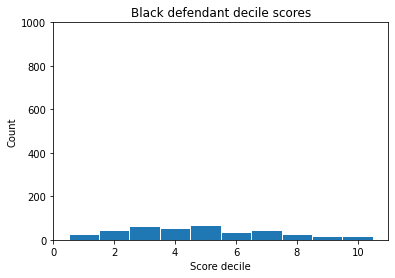

In [62]:
black_df = df_clean[df_clean['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,1000])
plt.xlim([0,11])
plt.title('Black defendant decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

Text(0.5, 0, 'Score decile')

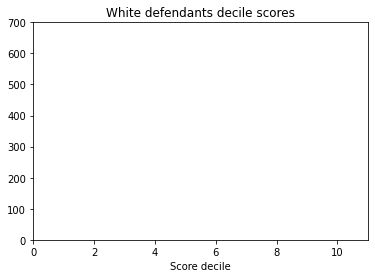

In [63]:
black_df = df_clean[df_clean['race'] == 'Caucasian']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('White defendants decile scores')
plt.xlabel('Score decile')

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [20]:
lr = LogisticRegression(solver='lbfgs')

In [21]:
df_crime = pd.get_dummies(df_clean['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df_clean['age_cat'],prefix='age')
df_race = pd.get_dummies(df_clean['race'],prefix='race')
df_gender = pd.get_dummies(df_clean['sex'],prefix='sex',drop_first=True)
df_score = pd.get_dummies(df_clean['score_text'] != 'Low',prefix='score_factor',drop_first=True)

In [22]:
df_lr = pd.concat([df_crime, df_age,df_race,df_gender,
                   df_clean['priors_count'],df_clean['two_year_recid']
                  ],axis=1)

In [23]:
lr.fit(df_lr,df_score.values.ravel())

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [42]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-2.934 (Intercept)
-0.344 crimefactor_M
1.035 age_25 - 45
-0.640 age_Greater than 45
1.182 age_Less than 25
0.203 race_African-American
0.387 race_Caucasian
-0.209 race_Hispanic
-0.396 race_Other
-0.522 sex_Male
0.392 priors_count
0.443 two_year_recid


Correcting for the seriousness of their crime, previous arrests, and future criminal behavior, these results show that Black defendants are 44% more likely to receive a higher COMPAS score than white defendants. (Correcting as in 

In [43]:
control = np.exp(-3.047) / (1 + np.exp(-3.047))
black_odds = np.exp(0.436) / (1 - control + (control * np.exp(0.436)))
print('Black defendants: %.4f' % black_odds)

Black defendants: 1.5091


In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import logit
catCols = ['score_text','age_cat','sex','race','c_charge_degree']
df_clean.loc[:,catCols] = df_clean.loc[:,catCols].astype('category')

# dfDummies = pd.get_dummies(data = dfFiltered.loc[dfFiltered['score_text'] != 'Low',:], columns=catCols)
dfDummies = pd.get_dummies(data = df_clean, columns=catCols)

# Clean column names
new_column_names = [col.lstrip().rstrip().lower().replace(" ", "_").replace("-", "_") for col in dfDummies.columns]
dfDummies.columns = new_column_names

# We want another variable that combines Medium and High
dfDummies['score_text_medhi'] = dfDummies['score_text_medium'] + dfDummies['score_text_high']


In [45]:
# R-style specification
formula = 'score_text_medhi ~ sex_female + age_cat_greater_than_45 + age_cat_less_than_25 + race_african_american + race_hispanic + race_other + priors_count + c_charge_degree_m + two_year_recid'

score_mod = logit(formula, data = dfDummies).fit()
print(score_mod.summary())

         Current function value: 0.535271
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       score_text_medhi   No. Observations:                 9999
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                            9
Date:                Tue, 09 Nov 2021   Pseudo R-squ.:                  0.1582
Time:                        20:01:39   Log-Likelihood:                -5352.2
converged:                      False   LL-Null:                       -6358.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.1892      0.153    -14.300      0.000      -2.489      -1.889
sex_female                

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
np.exp(0.571) / (1 - control + (control * np.exp(0.571)))

1.7103138200509116